# Bitcoin Price prediction using the machine learning neural network (LSTM) algorithm and technical analysis (TA) methods

<br> 
Bitcoin Price is predicted using technical analysis (TA) methods and long-short-term memory (LSTM).
<br> <br>

### Libraries 

In [25]:
import numpy as np 
seedNr = 7
np.random.seed(seedNr)

import datetime
import time

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import pandas_datareader.data as web

import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler

from IPython.display import display, HTML
import cryptocompare
from talib import abstract

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error 

from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

import nltk
#nltk.download()
#nltk.download('averaged_perceptron_tagger')


#Neuronal Network
import tensorflow as tf

np.random.seed(seedNr)
tf.random.set_seed(seedNr)
from tensorflow import keras

### Methods

In [26]:

#laedt Daten aus externen Quellen
def getCryptos(cryptos=['BTC'], columns=['volumefrom', 'open', 'low', 'high', 'close']):
    cryptoDic = {}
    index = []
    for cryptoName in cryptos:
        df = prepareData(cryptoName, 'EUR')
        if (df.empty == False) and (df[df.index.duplicated()].empty == True):           
            cryptoDic = df[columns]
            index = df.index
        
    df2 = pd.DataFrame(cryptoDic, index=index)
    df2['volume'] = df2['volumefrom']
    df2 = df2.drop(['volumefrom'], axis=1)
    return df2
    

#bereitet die geladenen Daten zur Analyse
def prepareData(cryptoName='BTC', FIAT='EUR'):
    btcHist = cryptocompare.get_historical_price_day(cryptoName, curr=FIAT, limit=2000)
    df_btc = pd.DataFrame(btcHist) 

    df_btc['time'] = [pd.to_datetime(dt, unit='s').date() for dt in df_btc['time']]
    df_btc.set_index('time', inplace=True)
    print('columns', df_btc.columns)
    return df_btc


    
#The values of the dataframe are standardized for graphical display.
def standard_scale_and_plot_line(df):
    stdc = StandardScaler()

    X_train_std = stdc.fit_transform(df)

    columns = df.columns
    index = df.index

    X_train_std_df = pd.DataFrame(X_train_std) 
    X_train_std_df.columns = columns
    X_train_std_df.index = index

    X_train_std_df.plot.line()
    
    
def select_features_from_model(model, tryingFeatArrayNumber, columns, X, y):
    featies = []
    model.fit(X, y)
    for idmf,mf in enumerate(tryingFeatArrayNumber):
        sfm = SelectFromModel(model, threshold=None, max_features=mf, prefit=True)#
        x_selected = sfm.transform(X)
        feature_idx = sfm.get_support()
        feature_names = columns[feature_idx]
        featies.append(feature_names)
    #
    print(f'features selected from a model', featies)
    return featies[0].tolist()


# feature selection
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=f_regression, k=5)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    #
    feat_names = X_cols[fs.get_support()]
    feat_indexes = fs.get_support()
    print(f'SELECTED NAMES: {feat_names}')
    #
    return X_train_fs, X_test_fs, fs, feat_names.tolist(), feat_indexes


def get_importance_regression_features_by_names(X,y,X_columns):
    # define the model
    model = RandomForestRegressor()
    # fit the model
    model.fit(X, y)
    # get importance
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    print('Ranking of feature importance:')
    
    feats = []
    for f in range(X.shape[1]):#column length from shape[1]
        if f > 0: #importance value
            print("%2d) %-*s %f" % (f, 30, X_columns[indices[f]], importances[indices[f]]))
            feats.append(X_columns[indices[f]])
    return feats
    
    
    #Generiere mir Time series daten in der richtigen Form
def create_dataset(X, y, time_steps=1):#current time prediction = 1
    Xs, ys = [], [] # history sets
    for i in range(len(X) - time_steps): #history row size
        v = X.iloc[i:(i + time_steps)].values # get the history value each row
        Xs.append(v) # append it into the list
        ys.append(y.iloc[i + time_steps]) # do the same for the target
    return np.array(Xs), np.array(ys) # return the history data



#### Raw data: Closing prices

In [27]:
#get symbols only
#['BTC', 'ETH', 'ADA', 'BNB', 'XEM', 'MIOTA', 'XLM', 'DASH', 'EOS', 'LINK', 'DOGE']
bp_symbols = ['BTC']

df_cryptos = getCryptos(bp_symbols)
display(df_cryptos)

columns Index(['high', 'low', 'open', 'volumefrom', 'volumeto', 'close',
       'conversionType', 'conversionSymbol'],
      dtype='object')


,open,low,high,close,volume
time,,,,,
2015-09-29,213.23,209.99,213.91,211.19,5932.43
2015-09-30,211.19,209.26,212.66,211.14,4149.87
2015-10-01,211.14,210.89,213.75,212.93,5052.86
2015-10-02,212.93,209.39,213.96,211.22,5001.33
2015-10-03,211.22,211.02,213.59,212.56,3546.87
...,...,...,...,...,...
2021-03-17,47804.64,45617.41,49166.71,49136.76,14192.90
2021-03-18,49136.76,47963.58,50319.04,48436.43,12565.08
2021-03-19,48436.43,47363.94,49903.56,48836.72,9539.34


#### Statistical values

In [28]:
df_cryptos.describe()

,open,low,high,close,volume
count,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000
mean,6294.029850,6091.041049,6488.123793,6318.275777,13001.621729
std,7426.084417,7136.600925,7702.861894,7484.952782,9428.814416
min,211.140000,209.260000,212.660000,211.140000,1931.510000
25%,945.910000,920.700000,965.240000,946.470000,7107.820000
50%,5537.220000,5386.320000,5652.400000,5539.500000,10471.100000
75%,8260.600000,8071.250000,8414.620000,8267.370000,15891.330000
max,50273.030000,49318.000000,50799.960000,50273.030000,104667.240000


#### Null value check

In [29]:
display(df_cryptos.isnull().sum())

open      0
low       0
high      0
close     0
volume    0
dtype: int64

#### Infinite value check

In [30]:
np.isinf(df_cryptos).values.sum() 

0

#### Plot the data

<AxesSubplot:xlabel='time'>

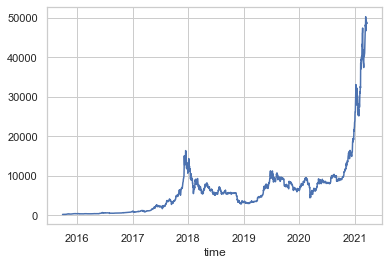

In [31]:
#standard_scale_and_plot_line(df_cryptos)
df_cryptos['close'].plot.line()

### Feature Engineering
is the process of using domain knowledge to extract features from raw data
<br>
<a href="https://tibilsolutions.com/data-solutions/feature-engineering/">Source</a>

#### Change the index data type to "to_datetime"

In [32]:
df_cryptos = df_cryptos.copy() 
df_cryptos.index = pd.to_datetime(df_cryptos.index)

#### Technical analysis (TA)
Technical analysis (also chart analysis) is a form of financial analysis. It examines the price and turnover history of the underlying (e.g. bitcoin) with the aim of evaluating the course

In [33]:
# directly
window = 5
#
SMA = abstract.SMA
DEMA = abstract.DEMA
EMA = abstract.EMA
KAMA = abstract.KAMA
HT_TRENDLINE = abstract.HT_TRENDLINE
BBANDS = abstract.BBANDS
MA = abstract.MA
MAVP = abstract.MAVP
MIDPOINT = abstract.MIDPOINT
MIDPRICE = abstract.MIDPRICE
SAR = abstract.SAR
SAREXT = abstract.SAREXT
T3 = abstract.T3
TEMA = abstract.TEMA
TRIMA = abstract.TRIMA
WMA = abstract.WMA
TRIMA = abstract.TRIMA
#
APO = abstract.APO
ADXR = abstract.ADXR
AROONOSC = abstract.AROONOSC
MFI = abstract.MFI
MOM = abstract.MOM
ROCP = abstract.ROCP
STOCHRSI = abstract.STOCHRSI
WCLPRICE = abstract.WCLPRICE
HT_TRENDMODE = abstract.HT_TRENDMODE
HT_DCPERIOD = abstract.HT_DCPERIOD
             
#
btc = df_cryptos.copy()
#
df_dic = {
    "SMA" : SMA(btc, timeperiod=(window+1)).tolist(),
    
    "DEMA" : DEMA(btc, timeperiod=(window+1)),
    "EMA" : EMA(btc, timeperiod=(window+1)),
    "KAMA" : KAMA(btc, timeperiod=(window+1)),
    "HT_TRENDLINE" : HT_TRENDLINE(btc, timeperiod=(window+1)),
    "MA" : MA(btc, timeperiod=(window+1)),
    "MIDPOINT" : MIDPOINT(btc, timeperiod=(window+1)),
    "MIDPRICE" : MIDPRICE(btc['high'], btc['low']),
    "SAR" : SAR(btc, timeperiod=(window+1)),
    
    "T3" : T3(btc, timeperiod=(window+1)),
    "TEMA" : TEMA(btc, timeperiod=(window+1)),
    "WMA" : WMA(btc, timeperiod=(window+1)),
    "TRIMA" : TRIMA(btc, timeperiod=(window+1)),
    "APO" : APO(btc, timeperiod=(window+1)),
    "ADXR" : ADXR(btc, timeperiod=(window+1)),
    "AROONOSC" : AROONOSC(btc, timeperiod=(window+1)),
    "MFI" : MFI(btc, timeperiod=(window+1)),
    "MOM" : MOM(btc, timeperiod=(window+1)),
    "ROCP" : ROCP(btc, timeperiod=(window+1)),
    "WCLPRICE" : WCLPRICE(btc, timeperiod=(window+1)),
    "HT_TRENDMODE" : HT_TRENDMODE(btc, timeperiod=(window+1)),
    "HT_DCPERIOD" : HT_DCPERIOD(btc, timeperiod=(window+1)),
    
    "SAREXT" : SAREXT(btc, timeperiod=(window+1)),
}

#
stochrsi = STOCHRSI(btc, timeperiod=(window+1))
df_dic['fastk'] = stochrsi['fastk']
df_dic['fastd'] = stochrsi['fastd']
#
brands = BBANDS(btc, timeperiod=(window+1))
df_dic['upperband'] = brands['upperband']
df_dic['middleband'] = brands['middleband']
df_dic['lowerband'] = brands['lowerband']
#
df_dic['close'] = btc['close']
#
ta_df = pd.DataFrame(df_dic, index=btc.index).iloc[window:,:]
#
ta_df = ta_df.dropna()
ta_df 

,SMA,DEMA,EMA,KAMA,HT_TRENDLINE,MA,MIDPOINT,MIDPRICE,SAR,T3,...,WCLPRICE,HT_TRENDMODE,HT_DCPERIOD,SAREXT,fastk,fastd,upperband,middleband,lowerband,close
time,,,,,,,,,,,,,,,,,,,,,
2015-12-01,344.173333,350.851833,340.782275,341.914366,316.614020,344.173333,346.815,326.895,278.812800,338.555477,...,344.4275,1,19.119973,278.812800,0.000000,66.666667,359.268139,344.173333,329.078528,342.33
2015-12-02,344.751667,347.542682,340.530197,341.889882,318.520944,344.751667,347.145,326.895,280.481544,342.979207,...,337.9575,1,19.180107,280.481544,0.000000,33.333333,358.848359,344.751667,330.654975,339.90
2015-12-03,343.220000,341.219018,338.010141,341.572709,319.756842,343.220000,344.455,326.895,282.116913,344.812884,...,335.5875,1,19.490513,282.116913,0.000000,0.000000,360.332350,343.220000,326.107650,331.71
2015-12-04,342.856667,338.783760,337.124386,341.517030,320.663160,342.856667,344.455,329.860,283.719575,344.866264,...,333.1475,1,19.711447,283.719575,11.144890,3.714963,360.556684,342.856667,325.156649,334.91
2015-12-05,343.128333,345.948321,341.580276,341.594529,321.946201,343.128333,344.455,329.860,285.290183,345.281617,...,349.5000,1,19.575752,285.290183,100.000000,37.048297,361.367315,343.128333,324.889352,352.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-17,48514.903333,49023.953455,48053.563730,48245.318425,43300.440182,48514.903333,48500.545,44824.550,44437.703956,48938.392461,...,48264.4100,1,21.604508,44437.703956,38.744731,19.072108,50867.420921,48514.903333,46162.385746,49136.76
2021-03-18,48616.766667,48934.225584,48162.954093,48247.423434,43681.854734,48616.766667,48500.545,44824.550,44812.280000,49090.719829,...,48788.8700,1,21.465656,44812.280000,30.005027,29.073784,50892.696954,48616.766667,46340.836379,48436.43
2021-03-19,48377.381667,49043.870092,48355.458638,48268.056738,44150.430214,48377.381667,48024.870,45219.275,45530.801600,49183.411277,...,48735.2350,1,21.337131,45530.801600,71.248746,46.666168,50153.356175,48377.381667,46601.407158,48836.72


#### Exploratory data analysis
examines and reviews data of which there is little knowledge about their interrelationships.

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>], dtype=object)

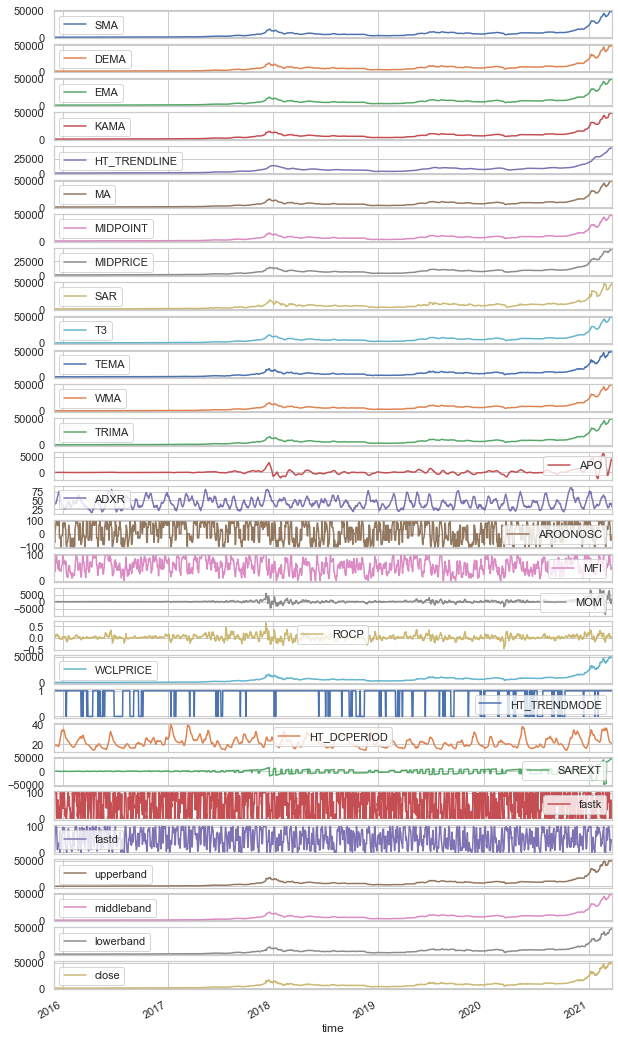

In [34]:

ta_df.plot.line(figsize=(10,20), subplots=True)

##### Correlation Matrix

is a statistical method used to evaluate the strength of relationship between two quantitative variables.
<br>
<a href="https://www.sciencedirect.com/topics/medicine-and-dentistry/correlation-analysis">Source</a>

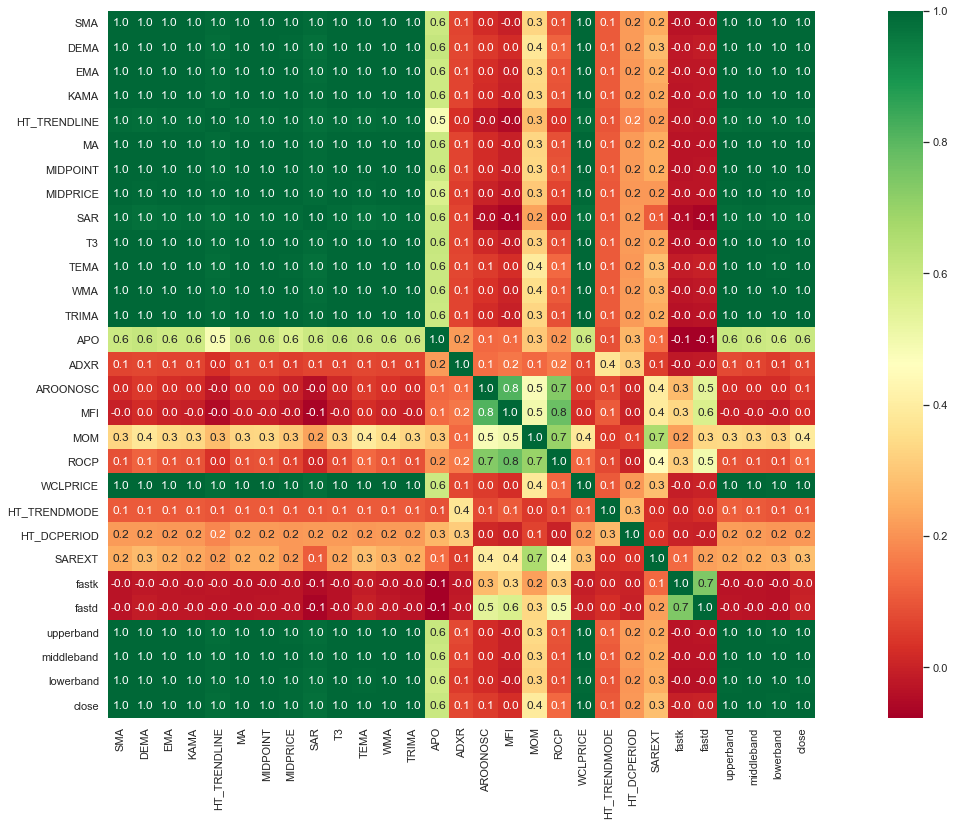

In [35]:
cols = ta_df.columns
cm = np.corrcoef(ta_df.T)
plt.figure(figsize = (26, 13))
color = plt.get_cmap('RdYlGn') 
color.set_bad('lightblue')
hm = sns.heatmap(cm,cbar=True, annot=True, square=True, fmt='.1f',
        annot_kws={'size':12}, yticklabels=cols, xticklabels=cols, cmap=color)

##### Features and Target variable
X = Regressor –> explanatory Variable, independent variable <br>
Y = Regressand –> variable to be explained, dependent variable or Response variable

In [36]:
X_df = ta_df.iloc[:,:-1]
X= X_df.values
X_cols = X_df.columns
#
y = ta_df.iloc[:,-1]

##### feature selection

In [37]:
# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print('Shape after split: ', X_train.shape)

# feature scaling
sc_x = StandardScaler()
sc_x.fit(X_train)
X_train_std = sc_x.transform(X_train)
X_test_std = sc_x.transform(X_test)
print('shape after standard scaled: ', X_train_std.shape)

Shape after split:  (1550, 28)
shape after standard scaled:  (1550, 28)


In [38]:
# selections

##1.
print('1. select from the importance ranking')
print()
feat_names1 = get_importance_regression_features_by_names(X,y,X_cols)
print()

##1.
print('2. select the best 5')
print()
X_train_fs, X_test_fs, fs, feat_names2, feat_indexes = select_features(X_train_std, y_train, X_test_std)
print('Shape after feature selection: ', X_train_fs.shape)
print()
print()

##2.
print('3. select the from a model: "RandomForestRegressor"')
print()
# the models hyperparameters are not tuned but you can do it
feat_names3 = select_features_from_model(RandomForestRegressor(), [100], X_cols, X, y)
print()
print()

1. select from the importance ranking

Ranking of feature importance:
 1) TEMA                           0.115384
 2) HT_TRENDLINE                   0.111129
 3) MIDPRICE                       0.109123
 4) KAMA                           0.073027
 5) DEMA                           0.056239
 6) MIDPOINT                       0.048600
 7) upperband                      0.031231
 8) WMA                            0.022179
 9) EMA                            0.018004
10) SMA                            0.016147
11) T3                             0.014954
12) MA                             0.010540
13) TRIMA                          0.008524
14) middleband                     0.008460
15) lowerband                      0.000597
16) SAREXT                         0.000178
17) HT_DCPERIOD                    0.000176
18) MFI                            0.000067
19) SAR                            0.000052
20) fastk                          0.000025
21) fastd                          0.000023
22) AP

['TEMA', 'DEMA', 'HT_TRENDLINE', 'MIDPRICE', 'WCLPRICE', 'KAMA', 'EMA', 'WMA']


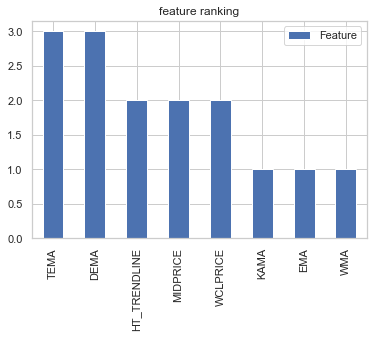

In [39]:
#found out the features which were selected the most

firstFeatures = 5
tokens = feat_names1[:firstFeatures] + feat_names2[:firstFeatures] + feat_names3[:firstFeatures]

fd = nltk.FreqDist(tokens)
feat_names = list(fd)
print(feat_names)

feat_dic = dict(fd)
#feat_dic = sorted(feat_dic, key=lambda x : feat_dic[x]) 

df_feat = pd.DataFrame(data=[feat_dic.values()], columns=feat_dic.keys()).T.sort_values(by=[0], ascending=False)
df_feat.plot.bar(title='feature ranking').legend(['Feature'], loc=1)

##### Scatterplot matrix
is a collection of scatterplots organized into a grid (or matrix). Each scatterplot shows the relationship between a pair of variables.<br>
<a href="https://www.jmp.com/support/help/en/15.2/index.shtml#page/jmp/scatterplot-matrix.shtml">Source</a>

,TEMA,DEMA,HT_TRENDLINE,MIDPRICE,WCLPRICE,KAMA,EMA,WMA,close
time,,,,,,,,,
2015-12-01,351.856497,350.851833,316.614020,326.895,344.4275,341.914366,340.782275,346.373333,342.33
2015-12-02,346.076675,347.542682,318.520944,326.895,337.9575,341.889882,340.530197,345.152381,339.90
2015-12-03,337.455008,341.219018,319.756842,326.895,335.5875,341.572709,338.010141,341.426190,331.71
2015-12-04,334.988393,338.783760,320.663160,329.860,333.1475,341.517030,337.124386,339.051905,334.91
2015-12-05,345.172110,345.948321,321.946201,329.860,349.5000,341.594529,341.580276,341.870000,352.72
...,...,...,...,...,...,...,...,...,...
2021-03-17,48688.391661,49023.953455,43300.440182,44824.550,48264.4100,48245.318425,48053.563730,48432.969048,49136.76
2021-03-18,48552.311279,48934.225584,43681.854734,44824.550,48788.8700,48247.423434,48162.954093,48410.548095,48436.43
2021-03-19,48711.888419,49043.870092,44150.430214,45219.275,48735.2350,48268.056738,48355.458638,48473.391905,48836.72


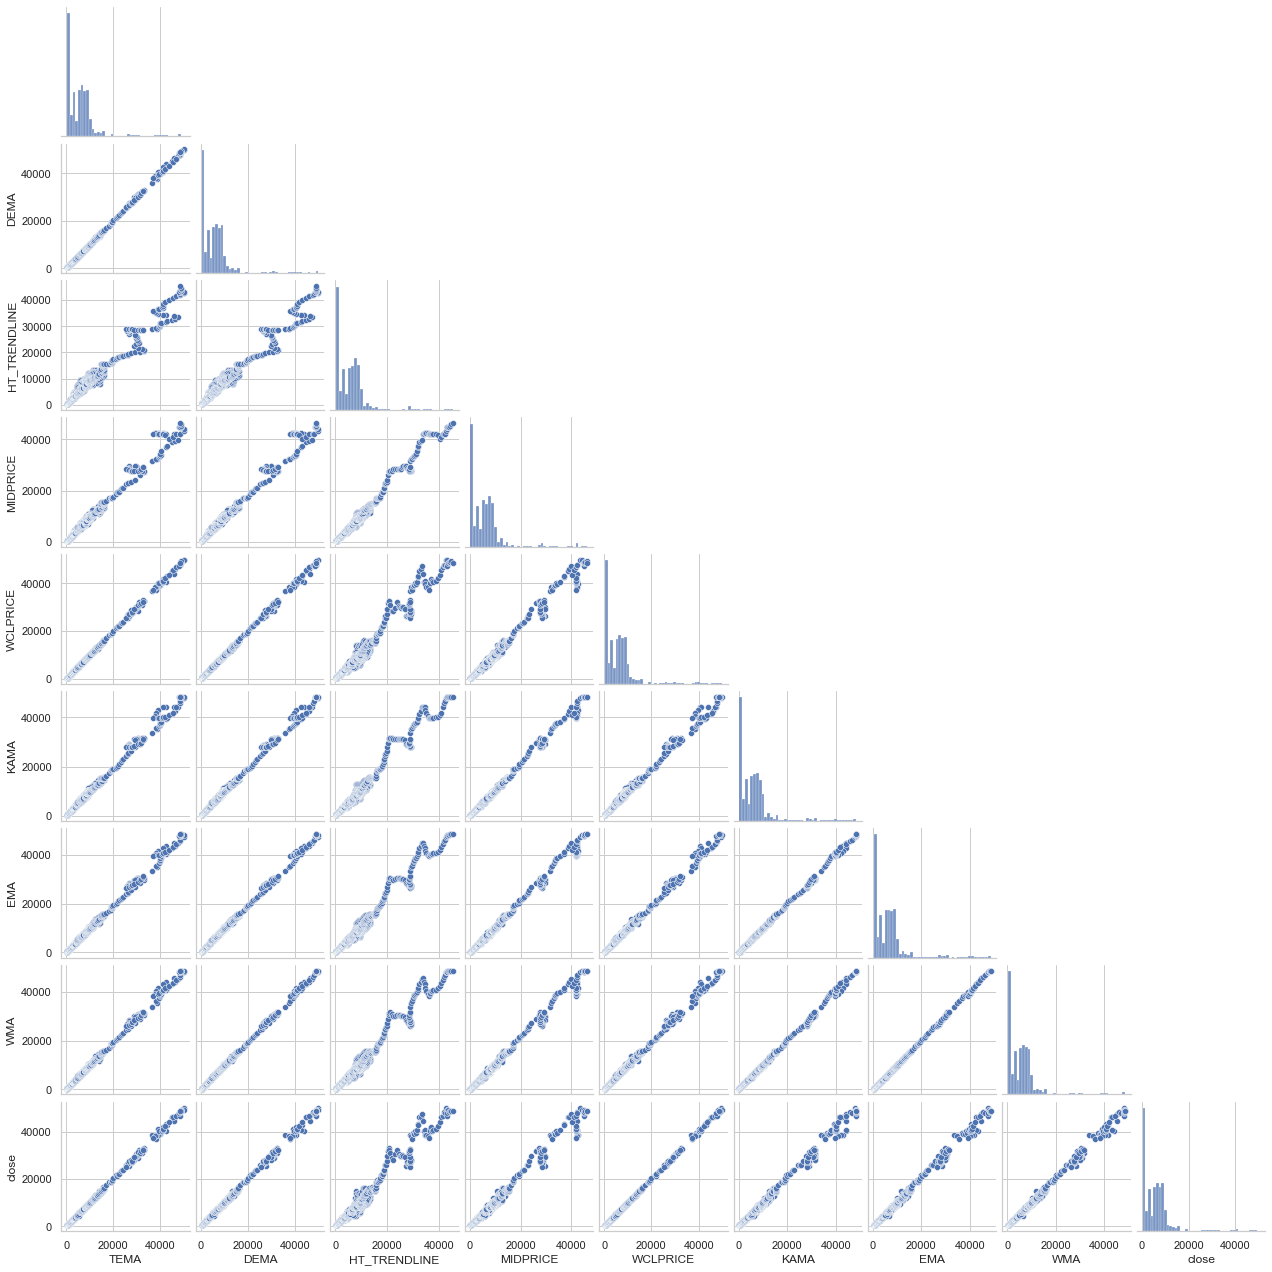

<Figure size 432x288 with 0 Axes>

In [40]:
#
df = pd.concat([ta_df[feat_names], y], axis=1)
display(df)
#
sns.set(style='whitegrid')
sns.pairplot(df, height=2, corner=True) 
#
plt.savefig('scatterplotMatrix.png')
plt.plot()
plt.show()
plt.clf() # Clean parirplot figure from sns 

##### make sure the independent variables or features are independent

dropping multi colinear features...
multi colinear features dropped!
to_drop ['DEMA', 'HT_TRENDLINE', 'MIDPRICE', 'WCLPRICE', 'KAMA', 'EMA', 'WMA']


<AxesSubplot:xlabel='time'>

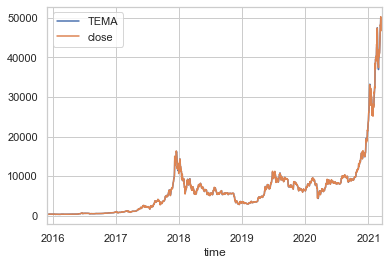

In [41]:

def drop_multi_colinear_features(df):
    print('dropping multi colinear features...')
    # Create correlation matrix
    corr_matrix = df.corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Find features with correlation greater than 0.95
    to_drop = [c for c in upper.columns if any(upper[c] > 0.95)]
    # Drop features 
    print('multi colinear features dropped!')
    print('to_drop', to_drop)
    df = df.drop(to_drop, axis=1)
    return df

X_selected_independent = drop_multi_colinear_features(ta_df.loc[:, feat_names])
X_selected_independent['close'] = y
df = X_selected_independent.copy()
#
df.plot.line()

*********************************************************



ARTIFICIAL NEURAL NETWORK: RNN - LONG TERM SHORT MEMORY



*********************************************************
<br>
"LSTM stands for long short term memory. It is a model or architecture that extends the memory of recurrent neural networks. Typically, recurrent neural networks have ‘short term memory’ in that they use persistent previous information to be used in the current neural network. Essentially, the previous information is used in the present task. That means we do not have a list of all of the previous information available for the neural node."<br>
<a href="https://hub.packtpub.com/what-is-lstm/">Source</a>

##### Note: 

##### Hyperparameters and Model selection

Model selection and evaluation are not processed here. We are going to use the LTSM model.<br>
For simplicity, the hyperparameters are also not optimized.

In [42]:
# preparation
dffts_df = df.copy().astype('int32')
#
X = dffts_df.drop('close', 1)
cols_X_lstm = X.columns.values
y = dffts_df['close']
cols_lstm = dffts_df.columns.values
index_lstm = dffts_df.index

#standard scaler
sc_lstm_x = StandardScaler()
sc_lstm_x.fit(X)
#
sc_lstm_y = StandardScaler()
sc_lstm_y.fit(y.values.reshape(-1,1))
#
X_lstm_std = sc_lstm_x.transform(X)
y_lstm = sc_lstm_y.transform(y.values.reshape(-1,1))

In [43]:
df = pd.DataFrame(X_lstm_std, columns=cols_X_lstm) #raw data
df.index = index_lstm
df['close'] = y_lstm

train_size = int(len(df)*0.7) #get the train size
test_size = len(df) - train_size # get the test size
train, test = df.iloc[0: train_size], df.iloc[train_size: len(df)]#test split
#
test_indices = test.index
#
print(test.columns)
print(len(train), len(test))

Index(['TEMA', 'close'], dtype='object')
1356 582


In [44]:
#
time_steps = window # how many line steps can I continue along?
X_train, y_train = create_dataset(train, train.close, time_steps)
X_test, y_test = create_dataset(test, test.close, time_steps)

#[batch, out_steps, features]
#batch=the rows, out_steps=how many row steps can I continue below?, existing columns in dataset
print((X_train.shape), y_train.shape)
print((X_train[2][0][0]), y_train.shape)

(1351, 5, 2) (1351,)
-0.82061049326686 (1351,)


In [45]:
model = keras.Sequential()
#
model.add(keras.layers.LSTM(
    units=256,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
#
model.add(keras.layers.Dropout(rate=0.1))
#
model.add(keras.layers.Dense(units=len(df.columns)))
#
model.compile(
    loss='mean_squared_error',
    optimizer=keras.optimizers.Adam(0.0001),
    metrics=[tf.metrics.MeanAbsoluteError()]
)

In [46]:
validation_split=0.1
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=16,
    validation_split=validation_split,
    verbose=1,
    shuffle=False
)

Epoch 1/20
76/76 [==============================] - 5s 24ms/step - loss: 0.3806 - mean_absolute_error: 0.5745 - val_loss: 0.0409 - val_mean_absolute_error: 0.1656
Epoch 2/20
76/76 [==============================] - 1s 15ms/step - loss: 0.0422 - mean_absolute_error: 0.1712 - val_loss: 0.0222 - val_mean_absolute_error: 0.1247
Epoch 3/20
76/76 [==============================] - 1s 15ms/step - loss: 0.0049 - mean_absolute_error: 0.0420 - val_loss: 0.0143 - val_mean_absolute_error: 0.0943
Epoch 4/20
76/76 [==============================] - 1s 16ms/step - loss: 0.0037 - mean_absolute_error: 0.0366 - val_loss: 0.0092 - val_mean_absolute_error: 0.0730
Epoch 5/20
76/76 [==============================] - 1s 15ms/step - loss: 0.0032 - mean_absolute_error: 0.0368 - val_loss: 0.0070 - val_mean_absolute_error: 0.0637
Epoch 6/20
76/76 [==============================] - 1s 17ms/step - loss: 0.0028 - mean_absolute_error: 0.0356 - val_loss: 0.0064 - val_mean_absolute_error: 0.0608
Epoch 7/20
76/76 [====

In [47]:
#
y_pred = model.predict(X_test)
y_pred_plot = sc_lstm_y.inverse_transform(y_pred)
#
y_test_plot = sc_lstm_y.inverse_transform(y_test)
#
print(X_test.shape)
print('---------')
print(y_pred.shape)
print(y_test.shape)

(577, 5, 2)
---------
(577, 2)
(577,)


19/19 - 0s - loss: 0.3481 - mean_absolute_error: 0.2447
MAE: 0.24467936158180237


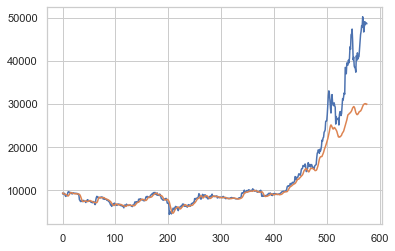

In [49]:
plt.plot(y_test_plot) 
plt.plot(y_pred_plot[:, y_pred_plot.shape[1]-1])
#
scores = model.evaluate(X_test, y_test, verbose=2)
print('MAE:', scores[1])